# Code Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from naive_bayes_classifier import NaiveBayes

# Reading the Data

In [23]:
inflammation_data = pd.read_csv('./inflammation_diagnosis.csv', delimiter=';')

# Inspecting the Data

In [24]:
inflammation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         120 non-null    float64
 1   nausea              120 non-null    object 
 2   lumbar_pain         120 non-null    object 
 3   urine_pushing       120 non-null    object 
 4   micturition_pains   120 non-null    object 
 5   burning_of_urethra  120 non-null    object 
 6   inflammation        120 non-null    object 
 7   nephritis           120 non-null    object 
dtypes: float64(1), object(7)
memory usage: 7.6+ KB


# Plot the data

plot with seaborn, use different colors and sort the values by colors

In [25]:
inflammation_data.replace(to_replace={'no': False, 'yes': True}, inplace=True)

inflammation_data

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,35.5,False,True,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False
2,35.9,False,True,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False
4,36.0,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
115,41.4,False,True,True,False,True,False,True
116,41.5,False,False,False,False,False,False,False
117,41.5,True,True,False,True,False,False,True
118,41.5,False,True,True,False,True,False,True


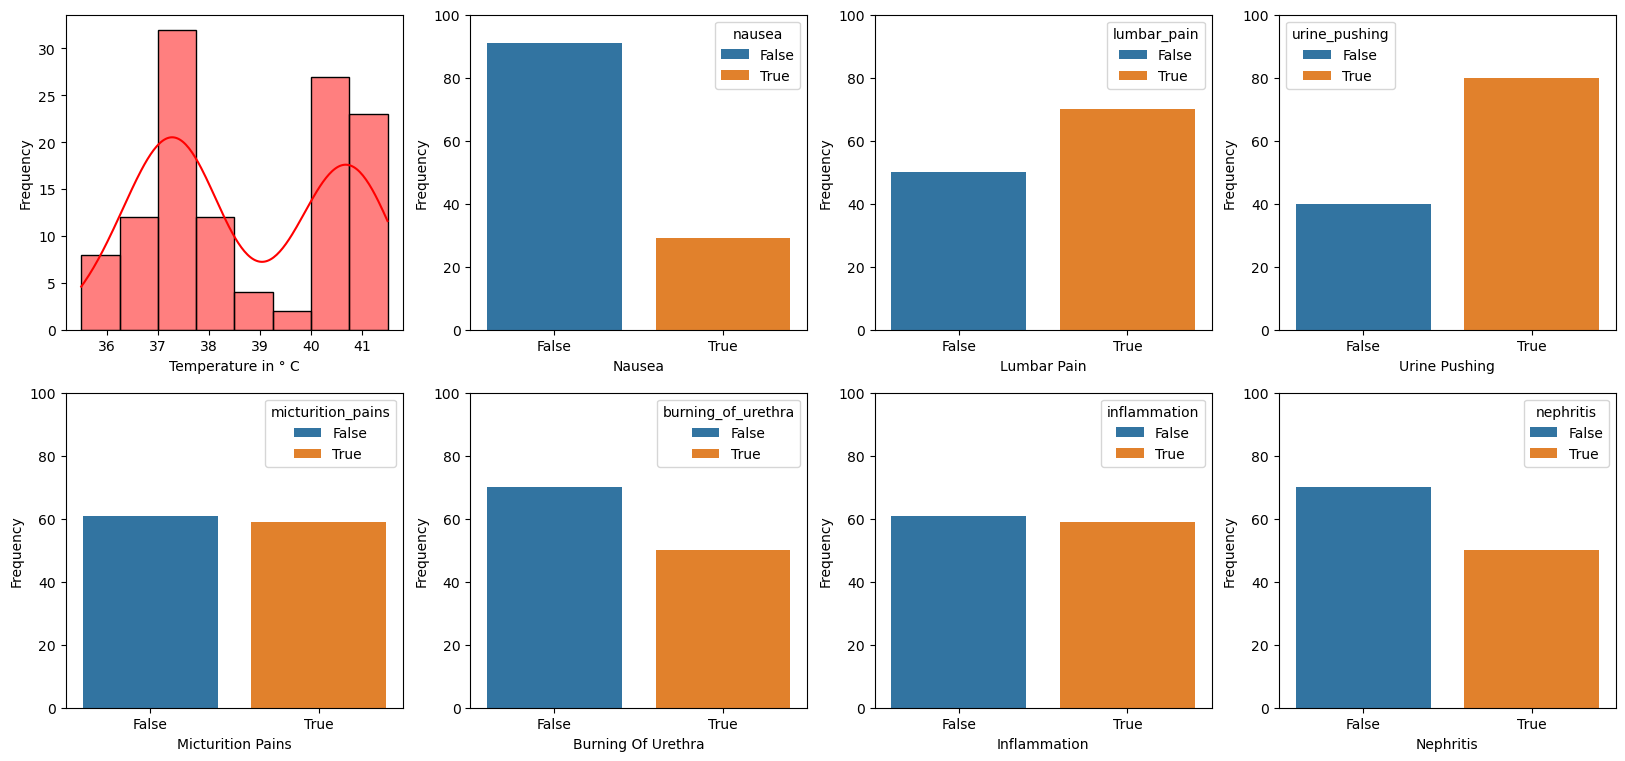

In [26]:
rows = 2
columns = 4
fig,ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,9))
[""]
index = 0 

for row in range(rows):
    for column in range(columns):
        nice_col_name = inflammation_data.columns.to_list()[index]
        nice_col_name = " ".join(word[0].upper() + word[1:] for word in nice_col_name.split("_"))
        
        
        if inflammation_data.columns[index] == 'temperature':
            s = sns.histplot(inflammation_data, ax=ax[row,column], x=inflammation_data.columns[column], kde=True, color='r')
            s.set(xlabel = 'Temperature in ° C', ylabel = "Frequency")
            
        else:
            b = sns.countplot(inflammation_data, x=inflammation_data.columns[index], ax=ax[row,column], hue=inflammation_data.columns[index])
            b.set(xlabel = nice_col_name, ylabel = 'Frequency')
            b.set_ylim(0,100)
            
        index += 1

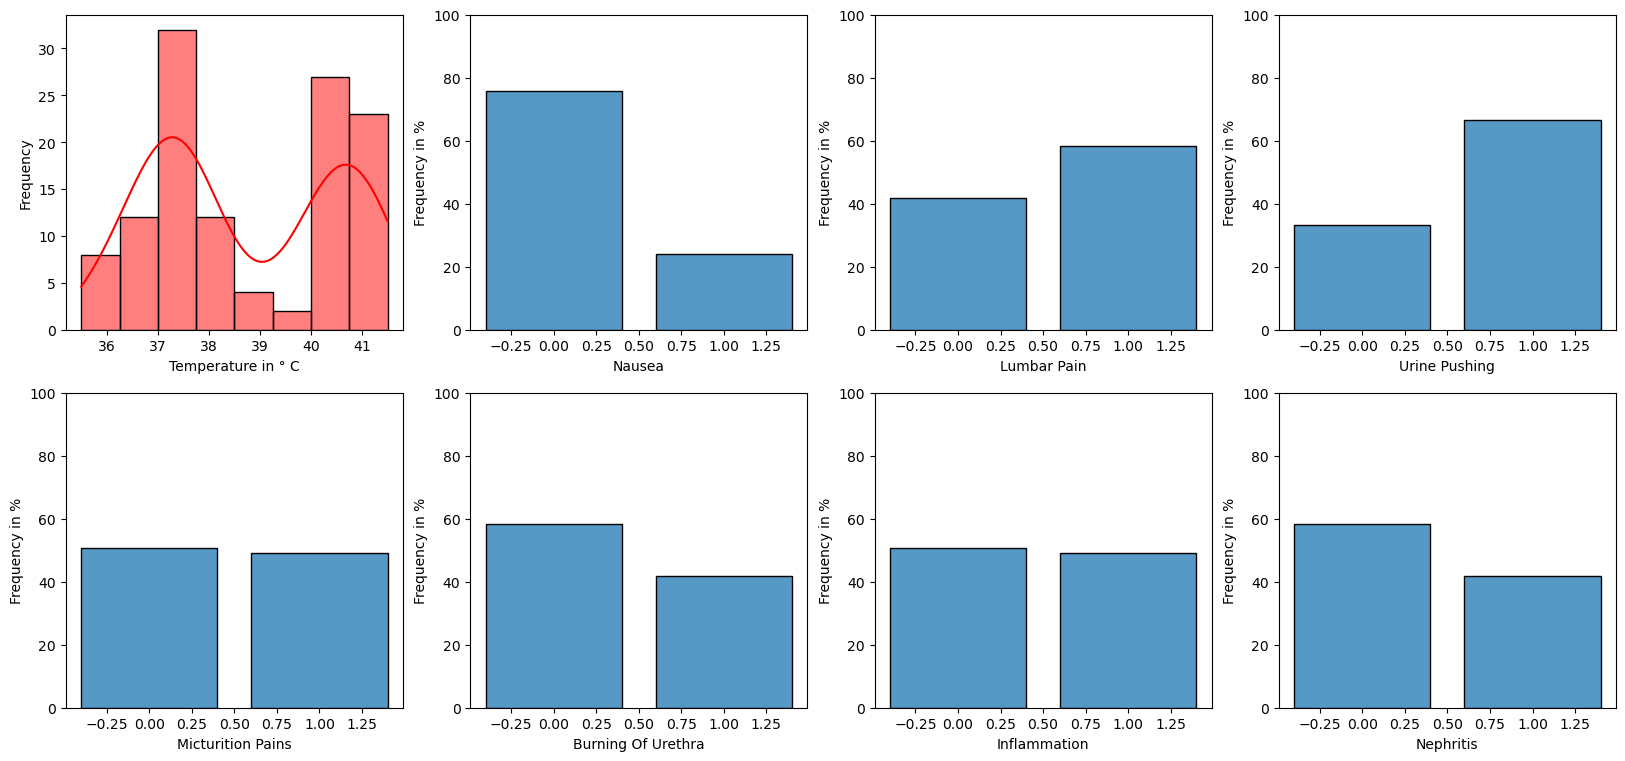

In [27]:
rows = 2
columns = 4
fig,ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,9))
[""]
index = 0 

for row in range(rows):
    for column in range(columns):
        nice_col_name = inflammation_data.columns.to_list()[index]
        nice_col_name = " ".join(word[0].upper() + word[1:] for word in nice_col_name.split("_"))
        
        
        if inflammation_data.columns[index] == 'temperature':
            s = sns.histplot(inflammation_data, ax=ax[row,column], x=inflammation_data.columns[column], kde=True, color='r')
            s.set(xlabel = 'Temperature in ° C', ylabel = "Frequency")
            
        else:
            b = sns.histplot(inflammation_data, ax=ax[row,column], x=inflammation_data.columns[index], stat='percent', discrete=True, shrink=.8)
            #b = sns.countplot(inflammation_data, x=inflammation_data.columns[index], ax=ax[row,column])
            b.set(xlabel = nice_col_name, ylabel = 'Frequency in %')
            b.set_ylim(0,100)
            
        index += 1

# Temperature distribution by diseased or healthy

From the temperature plot it seems as one could approximate two gaussian distributions that relate to the two categories diseased or healthy. To verify this, we plot the temperature grouped by the status of 'disease':

In [28]:
groupby_disease = inflammation_data[['temperature', 'disease']].groupby('disease')

KeyError: "['disease'] not in index"

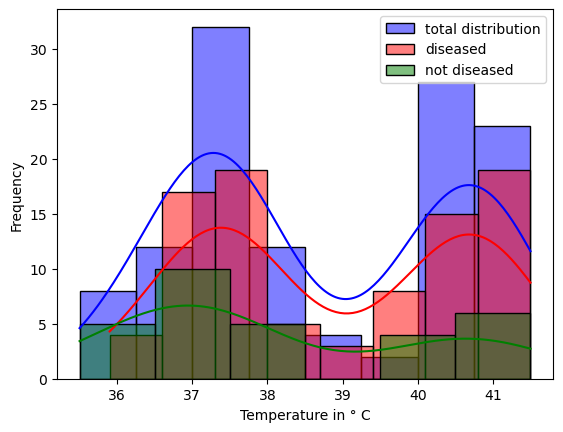

In [ ]:
diseased = groupby_disease.get_group(name=True)
healthy = groupby_disease.get_group(name=False)

sns.histplot(data=inflammation_data, x=inflammation_data['temperature'], bins=8, label='total distribution', color='b', kde=True)
sns.histplot(data=diseased, x=diseased['temperature'], label='diseased', color='r', kde=True)
sns.histplot(data=healthy, x=healthy['temperature'], label='not diseased', color='g', kde=True)

plt.ylabel('Frequency')
plt.xlabel('Temperature in ° C')

plt.legend()
plt.show()

It seems that, unlike expected from the total distribution, there are no two guassian distributions for diseased and healthy patients. One could assume such a distribution, as an elevated temperature is a typical sign for inflammation. However, looking only at inflammation and nephritis (out of which we generate the disease-column) and temperature, it is visible that there are multiple cases in which relatively low temperatures were measured for patients with either general inflammation or nephritis.

In [29]:
test = inflammation_data[['inflammation', 'nephritis', 'temperature']].sort_values(by='temperature')
print(test[(test.inflammation==True) | (test.nephritis==True)])

     inflammation  nephritis  temperature
1            True      False         35.9
3            True      False         36.0
6            True      False         36.2
8            True      False         36.3
9            True      False         36.6
..            ...        ...          ...
114          True       True         41.3
115         False       True         41.4
118         False       True         41.5
117         False       True         41.5
119         False       True         41.5

[90 rows x 3 columns]


# Creating Labels
## Transforming Nominal Data to Booleans

In [30]:
inflammation_data = inflammation_data.replace(to_replace='no', value=False)
inflammation_data = inflammation_data.replace(to_replace='yes', value=True)

inflammation_data

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,35.5,False,True,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False
2,35.9,False,True,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False
4,36.0,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...
115,41.4,False,True,True,False,True,False,True
116,41.5,False,False,False,False,False,False,False
117,41.5,True,True,False,True,False,False,True
118,41.5,False,True,True,False,True,False,True


KeyError: 'disease'

Checking if the columns are indeed of type boolean

In [8]:
inflammation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         120 non-null    float64
 1   nausea              120 non-null    bool   
 2   lumbar_pain         120 non-null    bool   
 3   urine_pushing       120 non-null    bool   
 4   micturition_pains   120 non-null    bool   
 5   burning_of_urethra  120 non-null    bool   
 6   inflammation        120 non-null    bool   
 7   nephritis           120 non-null    bool   
dtypes: bool(7), float64(1)
memory usage: 1.9 KB


## Adding Disease Labels 
Add the disease values to a new label-column and check if the values make sense

In [32]:
inflammation_data['disease'] = inflammation_data["inflammation"] | inflammation_data["nephritis"]
inflammation_data

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis,disease
0,35.5,False,True,False,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False,True
2,35.9,False,True,False,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False,True
4,36.0,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
115,41.4,False,True,True,False,True,False,True,True
116,41.5,False,False,False,False,False,False,False,False
117,41.5,True,True,False,True,False,False,True,True
118,41.5,False,True,True,False,True,False,True,True


In [33]:
grouped = inflammation_data.groupby(by="nausea")["disease"]
grouped.value_counts(normalize=True).reset_index()

,nausea,disease,proportion
0,False,True,0.67033
1,False,False,0.32967
2,True,True,1.00000


# Splitting the Data
Count the values of 'disease' to see how the data is distributed

In [10]:
inflammation_data['disease'].value_counts(True)

disease
True     0.75
False    0.25
Name: proportion, dtype: float64

# Drop duplicates to avoid the same patients for training and test set

<hr>
<h1> Think about when do drop data.....nicht, dass es was an der Wahrscheinlichkeit ändert
<br>
<hr>

In [12]:
#inflammation_data = inflammation_data.drop_duplicates()

In [ ]:
train = pd.concat([inflammation_data[inflammation_data['disease'] == True].sample(frac =0.8), inflammation_data[inflammation_data['disease'] == False].sample(frac = 0.8)])
test = inflammation_data.drop(train.index)

## Ensuring that the two dataframes do not share a column
The following merge shows duplicate rows across the two dataframes. If empty, there are no duplicates.

In [ ]:
set(list(test.index)).isdisjoint(list(train.index))

# Shows same values for training and test set, this are not the same patiens, just patients with the same values 

In [ ]:
result = train.merge(right=test, how='inner', indicator=False)
result

In [ ]:
train_1 = train
test_1 = test

test_1['original_index'] = range(1, len(test_1) + 1)
train_1['original_index'] = range(1, len(train_1) + 1)

result_1 = train_1.merge(right=test_1, how='inner', indicator=False)
result_1

# TESTING

In [10]:
t = NaiveBayes()
p,f = t.fit(inflammation_data, "disease")
print(p)
print("''''''''''''''")
f[False]


{'temperature':           False      True 
mean  38.140000  38.918889
std    1.925438   1.750242}
''''''''''''''


,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
False,1.0,0.333333,1.0,1.0,1.0,1.0,1.0
True,0.0,0.666667,0.0,0.0,0.0,0.0,0.0


<hr>
<br>

<ul>
<li>wenn ich fertig bin, so programmieren, dass man alle duplicates aus der temperature nimmt und dann nur noch einträgt</li>
<li>maybe auch schönes pd dataframe basteln als v-loook up </li>
<li>wenn temperatur neuer wert ist, dann die zwei closesten wählen und den durchschnitt nehmen</li>
</ul>
<br>
<hr>

In [11]:
training_tuples = round((len(inflammation_data)/10)*8)
df_training = inflammation_data.iloc[:training_tuples,:]
df_test = inflammation_data.iloc[training_tuples:,:]
df_test = df_test.reset_index(drop=True)

df_training

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis,disease
0,35.5,False,True,False,False,False,False,False,False
1,35.9,False,False,True,True,True,True,False,True
2,35.9,False,True,False,False,False,False,False,False
3,36.0,False,False,True,True,True,True,False,True
4,36.0,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
91,40.6,True,True,False,True,False,False,True,True
92,40.7,True,True,True,True,True,True,True,True
93,40.7,True,True,True,True,False,True,True,True
94,40.7,False,False,False,False,False,False,False,False


In [12]:
df_test = df_test.drop("disease",axis=1)
df_test

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
0,40.7,False,True,True,False,True,False,True
1,40.8,False,True,True,False,True,False,True
2,40.9,True,True,True,True,False,True,True
3,40.9,True,True,True,True,False,True,True
4,40.9,False,True,True,False,True,False,True
5,41.0,True,True,True,True,True,True,True
6,41.0,False,False,False,False,False,False,False
7,41.0,True,True,False,True,False,False,True
8,41.0,False,True,True,False,True,False,True
9,41.1,True,True,True,True,True,True,True


In [13]:
t = NaiveBayes()
gaus, discrete  = t.fit(df_training, "disease")
result = t.predict_probability(df_test, "disease")
result

{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.9849858775559194, True: 0.01501412244408053}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.9849531492313185, True: 0.015046850768681449}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.9849321737447537, True: 0.01506782625524629}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.9849401131936142, True: 0.015059886806385777}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}
{False: 0.0, True: 1.0}


,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis,disease
0,40.7,False,True,True,False,True,False,True,True
1,40.8,False,True,True,False,True,False,True,True
2,40.9,True,True,True,True,False,True,True,True
3,40.9,True,True,True,True,False,True,True,True
4,40.9,False,True,True,False,True,False,True,True
5,41.0,True,True,True,True,True,True,True,True
6,41.0,False,False,False,False,False,False,False,False
7,41.0,True,True,False,True,False,False,True,True
8,41.0,False,True,True,False,True,False,True,True
9,41.1,True,True,True,True,True,True,True,True


In [19]:
gaus["temperature"]

,False,True
mean,37.669231,38.290000
std,1.601941,1.459715


In [39]:
discrete[True]["nausea"][True]

0.2571428571428571

In [16]:
discrete[False]

,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis
False,1.0,0.230769,1.0,1.0,1.0,1.0,1.0
True,0.0,0.769231,0.0,0.0,0.0,0.0,0.0
